In [ ]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
track_feat_path = '../data/track_features/tf_mini.csv'
sess_feat_path = '../data/training_set/log_mini.csv'
sess_train_path='../data/training_set/train_sessions.csv'
sess_test_path='../data/training_set/test_sessions.csv'
sess_val_path='../data/training_set/val_sessions.csv'


track_feat = pd.read_csv(track_feat_path)
sess_feat = pd.read_csv(sess_feat_path)
sess_train = pd.read_csv(sess_train_path)
sess_test=pd.read_csv(sess_test_path)
sess_val=pd.read_csv(sess_val_path)

In [ ]:
sess_train.head()

,Unnamed: 0,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,20,0_0000a72b-09ac-412f-b452-9b9e79bded8f,1,20,t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,False,True,True,False,0,...,0,0,1,True,14,2018-07-15,True,user_collection,trackdone,fwdbtn
1,21,0_0000a72b-09ac-412f-b452-9b9e79bded8f,2,20,t_0632570b-b4b4-4c3c-b47c-443ec9fbaa11,True,True,True,False,0,...,0,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn
2,22,0_0000a72b-09ac-412f-b452-9b9e79bded8f,3,20,t_83024f1d-d384-4550-8b37-78a3c0cf0c42,False,False,False,False,0,...,0,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn
3,23,0_0000a72b-09ac-412f-b452-9b9e79bded8f,4,20,t_981c30c6-7f94-4b81-b4f1-9992dae4f6a3,False,False,False,False,0,...,0,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn
4,24,0_0000a72b-09ac-412f-b452-9b9e79bded8f,5,20,t_7e1e8880-1f59-4b55-b5b3-1b2335320932,False,False,False,False,0,...,1,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn


In [ ]:
sess_train['skipped'] = (sess_train.skip_1).astype('int32')
sess_test['skipped'] = (sess_test.skip_1).astype('int32')
sess_val['skipped'] = (sess_val.skip_1).astype('int32')

In [ ]:
sess_train

,Unnamed: 0,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,...,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skipped
0,20,0_0000a72b-09ac-412f-b452-9b9e79bded8f,1,20,t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,False,True,True,False,0,...,0,1,True,14,2018-07-15,True,user_collection,trackdone,fwdbtn,1
1,21,0_0000a72b-09ac-412f-b452-9b9e79bded8f,2,20,t_0632570b-b4b4-4c3c-b47c-443ec9fbaa11,True,True,True,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,1
2,22,0_0000a72b-09ac-412f-b452-9b9e79bded8f,3,20,t_83024f1d-d384-4550-8b37-78a3c0cf0c42,False,False,False,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,0
3,23,0_0000a72b-09ac-412f-b452-9b9e79bded8f,4,20,t_981c30c6-7f94-4b81-b4f1-9992dae4f6a3,False,False,False,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,0
4,24,0_0000a72b-09ac-412f-b452-9b9e79bded8f,5,20,t_7e1e8880-1f59-4b55-b5b3-1b2335320932,False,False,False,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134066,167875,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,16,20,t_360910e8-2a84-42b0-baf1-59abcf96a1f2,False,False,False,True,0,...,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0
134067,167876,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,17,20,t_aa2fff77-9b0a-4fa3-a685-ecef50310e8a,False,False,False,True,0,...,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0
134068,167877,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,18,20,t_f673e1b7-4ebe-4fc1-ac24-a9f25de70381,False,False,False,True,0,...,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0
134069,167878,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,19,20,t_e172e8e7-7161-42a9-acb0-d606346c8f87,False,False,False,True,0,...,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0


In [ ]:
sess_train['hist_user_behavior_reason_start'].value_counts()
sess_test['hist_user_behavior_reason_start'].value_counts()
sess_val['hist_user_behavior_reason_start'].value_counts()

fwdbtn        8191
trackdone     5584
clickrow      1757
backbtn       1191
appload        184
playbtn         15
trackerror      12
remote           7
endplay          2
Name: hist_user_behavior_reason_start, dtype: int64

In [ ]:
sess_train['hist_user_behavior_reason_end'].value_counts()

fwdbtn       64905
trackdone    46052
endplay      11892
backbtn      10566
logout         445
remote         211
Name: hist_user_behavior_reason_end, dtype: int64

In [ ]:
sess_train['context_type'].value_counts()

user_collection          53031
catalog                  30833
editorial_playlist       28768
radio                    17086
personalized_playlist     2371
charts                    1982
Name: context_type, dtype: int64

In [ ]:
# sess_feat = pd.get_dummies(sess_feat, columns=['hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'], prefix=['hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'], drop_first=True)

In [ ]:
sess_train.sample(3)

,Unnamed: 0,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,...,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skipped
18100,22554,0_01f7f498-2fe2-4872-8929-a7837eb5e69a,6,10,t_9a03f300-6504-4c7a-92b1-4cd88354ee74,False,False,False,True,0,...,0,0,False,23,2018-07-14,True,catalog,trackdone,trackdone,0
93838,117873,0_0a58492c-1bea-4d01-9c3f-0c0c0d432d1b,2,20,t_0f662abf-b7de-47f6-80a5-6587ecdbe9d4,False,True,True,False,0,...,0,0,False,0,2018-07-15,False,catalog,clickrow,endplay,1
101623,127236,0_0b2a9c0e-8f59-4765-939e-c9f4df3f3936,8,11,t_0ef6d2c8-faf9-4ebe-ac75-2bade8696a3d,True,True,True,False,0,...,0,0,False,19,2018-07-14,True,user_collection,fwdbtn,fwdbtn,1


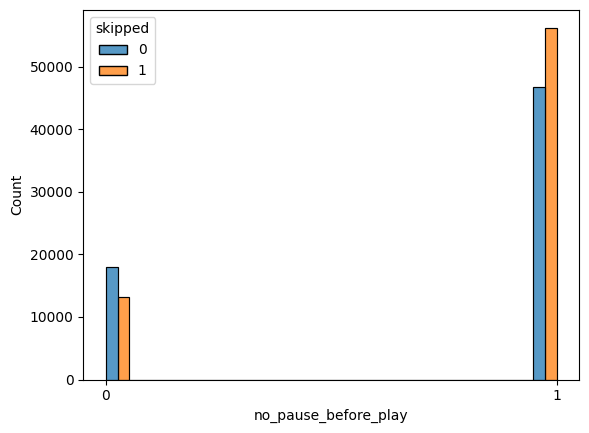

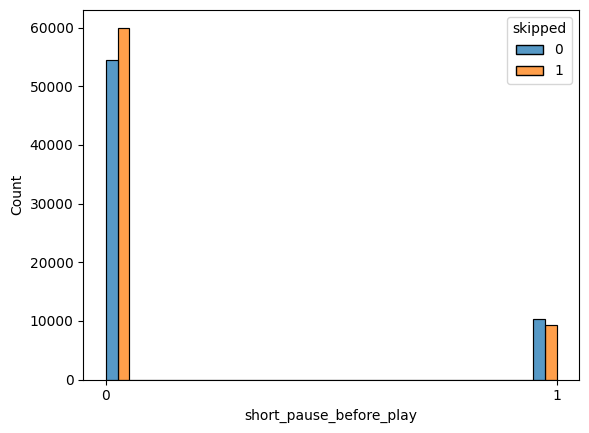

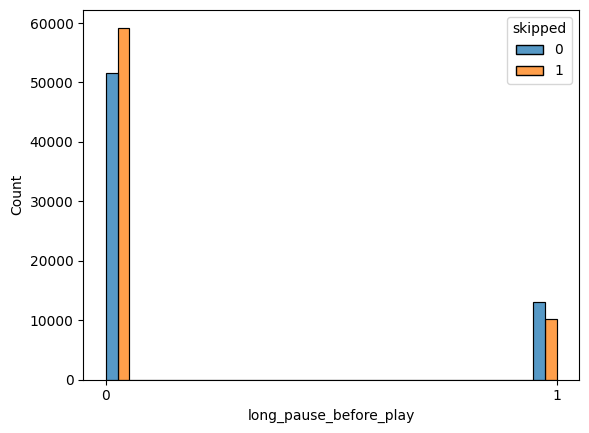

In [ ]:
for l in ['no_pause_before_play', 'short_pause_before_play', 'long_pause_before_play']:
  ax=sns.histplot(data=sess_train, x=l, hue='skipped', multiple='dodge')
  ax.set_xticks([0, 1])
  plt.show()

In [ ]:
min_dur, max_dur = track_feat['duration'].min(), track_feat['duration'].max()
track_feat['duration'] = track_feat['duration'].apply(lambda x: (x - min_dur)/max_dur)
min_pop, max_pop = track_feat['us_popularity_estimate'].min(), track_feat['us_popularity_estimate'].max()
track_feat['us_popularity_estimate'] = track_feat['us_popularity_estimate'].apply(lambda x: (x - min_pop)/max_pop)
track_feat['release_year'] = pd.factorize(track_feat['release_year'])[0] + 1
track_feat = pd.get_dummies(track_feat, columns=['key', 'mode', 'time_signature'], prefix=['key', 'mode', 'time_signature'], drop_first=True)

track_feat.sample()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,key_7,key_8,key_9,key_10,key_11,mode_minor,time_signature_1,time_signature_3,time_signature_4,time_signature_5
42196,t_604f3165-b00b-49e9-b999-b8c7c8b4d919,0.042049,66,0.098529,0.863153,0.18141,0.191012,0.204324,4.985221,0.168432,...,0,0,1,0,0,1,0,0,1,0


In [ ]:
track_feat.columns

Index(['track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'liveness',
       'loudness', 'mechanism', 'organism', 'speechiness', 'tempo', 'valence',
       'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
       'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
       'acoustic_vector_6', 'acoustic_vector_7', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'mode_minor', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

In [ ]:
sess_train['session_length'].min()

10

## Transform data into Sequences

In [ ]:
sess_group = sess_train.sort_values(by=["session_position"]).groupby("session_id")

sess_track_data = pd.DataFrame(
    data={
        "session_id": list(sess_group.groups.keys()),
        "track_ids": list(sess_group.track_id_clean.apply(list)),
        "skipped": list(sess_group.skipped.apply(list))
    }
)

sess_group_test = sess_test.sort_values(by=["session_position"]).groupby("session_id")

sess_track_data_test = pd.DataFrame(
    data={
        "session_id": list(sess_group_test.groups.keys()),
        "track_ids": list(sess_group_test.track_id_clean.apply(list)),
        "skipped": list(sess_group_test.skipped.apply(list))
    }
)

sess_group_val = sess_val.sort_values(by=["session_position"]).groupby("session_id")

sess_track_data_val = pd.DataFrame(
    data={
        "session_id": list(sess_group_val.groups.keys()),
        "track_ids": list(sess_group_val.track_id_clean.apply(list)),
        "skipped": list(sess_group_val.skipped.apply(list))
    }
)


In [ ]:
sess_track_data_val

,session_id,track_ids,skipped
0,0_00018b58-deb8-4f98-ac5e-d7e01b346130,"[t_283866a4-62dc-4798-9a51-fde54c8c5ff6, t_2ed...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,0_00027db1-ffe5-4b00-8eeb-8d8188451298,"[t_bacf06d3-9185-4183-84ea-ff0db51475ce, t_571...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,0_00052b3c-a5f9-4b04-90ef-6378777d89d8,"[t_a7aa673d-9c8b-4e6a-985e-ec91ed5727e9, t_c81...","[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,0_00070b9a-c9da-404f-81d0-c22f4f79b933,"[t_5552d909-a307-4e84-b80d-92f75c3bfc22, t_07d...","[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]"
4,0_000e69be-6083-48e9-81c7-8e45ff1794df,"[t_cfa44a82-e314-44c9-9596-d78a8b707afa, t_bac...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
995,0_0ea2ef38-66c1-4566-8d60-0bf3b3cb0f3f,"[t_7533e7ff-568e-448b-904e-fc0c3a9ec87e, t_87a...","[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]"
996,0_0ea9c6c6-25aa-48d5-b25f-a08e582238e0,"[t_312b3509-48c1-4928-a6e5-d3e7a51c216b, t_78b...","[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
997,0_0eac164c-f209-4590-8608-a56e67658952,"[t_9bace756-b6bf-4e5a-9723-05b8f27d1ebe, t_204...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
998,0_0eacbee7-9868-48a0-9ab0-f86069329f50,"[t_900f7a9e-e082-4378-8705-ecce236cddf6, t_c90...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ..."


In [ ]:
sequence_length = 7
step_size = 3


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


sess_track_data['track_ids'] = sess_track_data['track_ids'].apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

sess_track_data['skipped'] = sess_track_data['skipped'].apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

sess_track_data_test['track_ids'] = sess_track_data_test['track_ids'].apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

sess_track_data_test['skipped'] = sess_track_data_test['skipped'].apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

sess_track_data_val['track_ids'] = sess_track_data_val['track_ids'].apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

sess_track_data_val['skipped'] = sess_track_data_val['skipped'].apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)


In [ ]:
sess_track_data_test.isna().sum()

session_id    0
track_ids     0
skipped       0
dtype: int64

In [ ]:
sess_tracks = sess_track_data[["session_id", "track_ids"]].explode(
    "track_ids", ignore_index=True
)
tracks_skipped = sess_track_data[["skipped"]].explode("skipped", ignore_index=True)

sess_tracks_test = sess_track_data_test[["session_id", "track_ids"]].explode(
    "track_ids", ignore_index=True
)
tracks_skipped_test = sess_track_data_test[["skipped"]].explode("skipped", ignore_index=True)

sess_tracks_val = sess_track_data_val[["session_id", "track_ids"]].explode(
    "track_ids", ignore_index=True
)
tracks_skipped_val = sess_track_data_val[["skipped"]].explode("skipped", ignore_index=True)

In [ ]:
sess_tracks_test.isna().sum()

session_id    0
track_ids     0
dtype: int64

In [ ]:
sess_train.columns

Index(['Unnamed: 0', 'session_id', 'session_position', 'session_length',
       'track_id_clean', 'skip_1', 'skip_2', 'skip_3', 'not_skipped',
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'skipped'],
      dtype='object')

In [ ]:
sess_train.head()

,Unnamed: 0,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,...,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skipped
0,20,0_0000a72b-09ac-412f-b452-9b9e79bded8f,1,20,t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,False,True,True,False,0,...,0,1,True,14,2018-07-15,True,user_collection,trackdone,fwdbtn,1
1,21,0_0000a72b-09ac-412f-b452-9b9e79bded8f,2,20,t_0632570b-b4b4-4c3c-b47c-443ec9fbaa11,True,True,True,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,1
2,22,0_0000a72b-09ac-412f-b452-9b9e79bded8f,3,20,t_83024f1d-d384-4550-8b37-78a3c0cf0c42,False,False,False,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,0
3,23,0_0000a72b-09ac-412f-b452-9b9e79bded8f,4,20,t_981c30c6-7f94-4b81-b4f1-9992dae4f6a3,False,False,False,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,0
4,24,0_0000a72b-09ac-412f-b452-9b9e79bded8f,5,20,t_7e1e8880-1f59-4b55-b5b3-1b2335320932,False,False,False,False,0,...,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn,0


In [ ]:
# cols = ['session_id', 'track_id_clean', 'hist_user_behavior_n_seekfwd',
#         'hist_user_behavior_n_seekback',
#         'hist_user_behavior_reason_start_backbtn',
#        'hist_user_behavior_reason_start_clickrow',
#        'hist_user_behavior_reason_start_endplay',
#        'hist_user_behavior_reason_start_fwdbtn',
#        'hist_user_behavior_reason_start_playbtn',
#        'hist_user_behavior_reason_start_remote',
#        'hist_user_behavior_reason_start_trackdone',
#        'hist_user_behavior_reason_start_trackerror',
#        'hist_user_behavior_reason_end_clickrow',
#        'hist_user_behavior_reason_end_endplay',
#        'hist_user_behavior_reason_end_fwdbtn',
#        'hist_user_behavior_reason_end_logout',
#        'hist_user_behavior_reason_end_remote',
#        'hist_user_behavior_reason_end_trackdone']
cols = ['session_id', 'track_id_clean', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
sess_train = sess_train[cols]
sess_test = sess_test[cols]
sess_val = sess_val[cols]

In [ ]:
sess_track_joined = sess_train#.join(track_feat.set_index('track_id'), on='track_id_clean')
sess_track_joined_test = sess_test
sess_track_joined_val = sess_val

In [ ]:
sess_track_joined.columns

Index(['session_id', 'track_id_clean', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_reason_start',
       'hist_user_behavior_reason_end'],
      dtype='object')

In [ ]:
sess_tracks_seq = pd.concat([sess_tracks, tracks_skipped], axis=1)
sess_tracks_seq = sess_tracks_seq.join(
    sess_track_joined.set_index("session_id"), on="session_id"
)
#sess_tracks_seq.shape

sess_tracks_seq_test = pd.concat([sess_tracks_test, tracks_skipped_test], axis=1)
sess_tracks_seq_test = sess_tracks_seq_test.join(
    sess_track_joined_test.set_index("session_id"), on="session_id"
)
#sess_tracks_seq.shape

sess_tracks_seq_val = pd.concat([sess_tracks_val, tracks_skipped_val], axis=1)
sess_tracks_seq_val = sess_tracks_seq_val.join(
    sess_track_joined_val.set_index("session_id"), on="session_id"
)
sess_tracks_seq.shape

(700138, 8)

In [ ]:
sess_tracks_seq_test.isna().sum()

session_id                         0
track_ids                          0
skipped                            0
track_id_clean                     0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
dtype: int64

In [ ]:
sess_tracks_seq_test['track_ids']

0        [t_0479f24c-27d2-46d6-a00c-7ec928f2b539, t_909...
0        [t_0479f24c-27d2-46d6-a00c-7ec928f2b539, t_909...
0        [t_0479f24c-27d2-46d6-a00c-7ec928f2b539, t_909...
0        [t_0479f24c-27d2-46d6-a00c-7ec928f2b539, t_909...
0        [t_0479f24c-27d2-46d6-a00c-7ec928f2b539, t_909...
                               ...                        
39523                                                  NaN
39524                                                  NaN
39525                                                  NaN
39526                                                  NaN
39527                                                  NaN
Name: track_ids, Length: 123068, dtype: object

In [ ]:
sess_tracks_seq.track_ids = sess_tracks_seq['track_ids'].apply(
    lambda x: ",".join(x)
)
sess_tracks_seq.skipped = sess_tracks_seq['skipped'].apply(
    lambda x: ",".join([str(v) for v in x])
)

sess_tracks_seq.rename(
    columns={"track_ids": "sequence_track_ids", "skipped": "sequence_skipped"},
    inplace=True,
)

sess_tracks_seq_test.track_ids = sess_tracks_seq_test['track_ids'].apply(
    lambda x: ",".join(x)
)
sess_tracks_seq_test.skipped = sess_tracks_seq_test['skipped'].apply(
    lambda x: ",".join([str(v) for v in x])
)

sess_tracks_seq_test.rename(
    columns={"track_ids": "sequence_track_ids", "skipped": "sequence_skipped"},
    inplace=True,
)

sess_tracks_seq_val.track_ids = sess_tracks_seq_val['track_ids'].apply(
    lambda x: ",".join(x)
)
sess_tracks_seq_val.skipped = sess_tracks_seq_val['skipped'].apply(
    lambda x: ",".join([str(v) for v in x])
)

sess_tracks_seq_val.rename(
    columns={"track_ids": "sequence_track_ids", "skipped": "sequence_skipped"},
    inplace=True,
)

In [ ]:
sess_tracks_seq.drop('track_id_clean', axis=1, inplace=True)
sess_tracks_seq.columns

sess_tracks_seq_test.drop('track_id_clean', axis=1, inplace=True)
sess_tracks_seq_test.columns

sess_tracks_seq_val.drop('track_id_clean', axis=1, inplace=True)
sess_tracks_seq_val.columns

Index(['session_id', 'sequence_track_ids', 'sequence_skipped',
       'hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [ ]:
sess_tracks_seq.sample(5)

,session_id,sequence_track_ids,sequence_skipped,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_reason_start,hist_user_behavior_reason_end
16978,0_0638ac2a-5d7a-4059-9699-e56c65fd760b,"t_29392342-f5d1-41f6-9042-ddf5a432bb22,t_8f7de...","0,1,1,1,1,0,0",0,0,trackdone,fwdbtn
25441,0_0974c112-55d8-4502-95e7-fbc13a2cdb31,"t_edbdbaef-e480-4eb4-acee-79830d66bca5,t_2179b...","0,0,0,0,0,0,1",0,0,fwdbtn,fwdbtn
10072,0_03a0da0e-85f3-4926-a328-c8ffd9434bd6,"t_7d4a4ed2-f1fe-497c-8973-dfb98c7b25b7,t_e8e2d...","0,0,0,0,0,1,0",0,0,trackdone,trackdone
3136,0_01151fca-8196-4195-9242-a4ab60a91148,"t_992664c2-0754-4eb1-b0c3-0a6aa87697f5,t_42d15...","1,0,0,0,0,0,0",0,0,trackdone,logout
12312,0_046da602-63fc-4644-8be6-9b95a0e89e36,"t_a3ef62d1-9f56-4429-bc36-a4503a682bdb,t_8c62f...","0,1,0,0,0,0,1",0,0,clickrow,endplay


In [ ]:
#random_selection = np.random.rand(len(sess_tracks_seq.index)) <= 0.85
#train_data = sess_tracks_seq[random_selection]
#test_data = sess_tracks_seq[~random_selection]

train_data=sess_tracks_seq
test_data=sess_tracks_seq_test
val_data=sess_tracks_seq_val

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)
val_data.to_csv("val_data.csv", index=False, sep="|", header=False)

In [ ]:
train_data

,session_id,sequence_track_ids,sequence_skipped,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_0000a72b-09ac-412f-b452-9b9e79bded8f,"t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,t_06325...","1,1,0,0,0,1,1",0,1,trackdone,fwdbtn
0,0_0000a72b-09ac-412f-b452-9b9e79bded8f,"t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,t_06325...","1,1,0,0,0,1,1",0,0,fwdbtn,fwdbtn
0,0_0000a72b-09ac-412f-b452-9b9e79bded8f,"t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,t_06325...","1,1,0,0,0,1,1",0,0,fwdbtn,fwdbtn
0,0_0000a72b-09ac-412f-b452-9b9e79bded8f,"t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,t_06325...","1,1,0,0,0,1,1",0,0,fwdbtn,fwdbtn
0,0_0000a72b-09ac-412f-b452-9b9e79bded8f,"t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,t_06325...","1,1,0,0,0,1,1",0,0,fwdbtn,fwdbtn
...,...,...,...,...,...,...,...
39527,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,"t_f80ee4db-b284-4ef7-bdde-604ea6354f3c,t_e76ba...","0,0,0,0,0,0,0",0,0,trackdone,trackdone
39527,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,"t_f80ee4db-b284-4ef7-bdde-604ea6354f3c,t_e76ba...","0,0,0,0,0,0,0",0,0,trackdone,trackdone
39527,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,"t_f80ee4db-b284-4ef7-bdde-604ea6354f3c,t_e76ba...","0,0,0,0,0,0,0",0,0,trackdone,trackdone
39527,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,"t_f80ee4db-b284-4ef7-bdde-604ea6354f3c,t_e76ba...","0,0,0,0,0,0,0",0,0,trackdone,trackdone


In [ ]:
CSV_HEADER = list(sess_tracks_seq.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "session_id": list(sess_feat['session_id'].unique()),
    "track_id": list(track_feat['track_id'].unique()),
    'hist_user_behavior_reason_start': list(sess_feat['hist_user_behavior_reason_start'].unique()),
    'hist_user_behavior_reason_end': list(sess_feat['hist_user_behavior_reason_end'].unique())
}

SESSION_FEATURES = ['hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']

TRACK_FEATURES = ['release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'liveness',
       'loudness', 'mechanism', 'organism', 'speechiness', 'tempo', 'valence', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'mode_minor', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5']

In [ ]:

def process(features):
        track_ids = features["sequence_track_ids"]
        sequence_track_ids = tf.strings.split(track_ids, ",").to_tensor()

        features["target_track_id"] = sequence_track_ids[:, -1]
        features["sequence_track_ids"] = sequence_track_ids[:, :-1]

        skipped = features["sequence_skipped"]
        sequence_skipped = tf.strings.to_number(
            tf.strings.split(skipped, ","), tf.dtypes.float32
        ).to_tensor()

        target = sequence_skipped[:, -1]
        features["sequence_skipped"] = sequence_skipped[:, :-1]

        return features, target
    
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):

    dataset = tf.data.experimental.make_csv_dataset(csv_file_path, batch_size=batch_size, column_names=CSV_HEADER, 
                                                    num_epochs=1, header=False, field_delim="|", shuffle=shuffle).map(process)

    return dataset


In [ ]:

def create_model_inputs():
    return {
        "session_id": layers.Input(name="session_id", shape=(1,), dtype=tf.string),
        "sequence_track_ids": layers.Input(
            name="sequence_track_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_track_id": layers.Input(
            name="target_track_id", shape=(1,), dtype=tf.string
        ),
        "sequence_skipped": layers.Input(
            name="sequence_skipped", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        "hist_user_behavior_reason_start": layers.Input(name="hist_user_behavior_reason_start", shape=(1,), dtype=tf.string),
        "hist_user_behavior_reason_end": layers.Input(name="hist_user_behavior_reason_end", shape=(1,), dtype=tf.string),
    }


In [ ]:

def encode_input_features(
    inputs,
    include_session_id=True,
    include_session_features=True,
    include_track_features=True,
):

    transformer_feat_enc = []
    other_feat_enc = []

    other_feature_names = []
    if include_session_id:
        other_feature_names.append("session_id")
    if include_session_features:
        other_feature_names.extend(SESSION_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        other_feat_enc.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(other_feat_enc) > 1:
        other_feat_enc = layers.concatenate(other_feat_enc)
    elif len(other_feat_enc) == 1:
        other_feat_enc = other_feat_enc[0]
    else:
        other_feat_enc = None

    ## Create a movie embedding encoder
    track_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["track_id"]
    track_embedding_dims = int(math.sqrt(len(track_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    track_index_lookup = StringLookup(
        vocabulary=track_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="track_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    track_embedding_encoder = layers.Embedding(
        input_dim=len(track_vocabulary),
        output_dim=track_embedding_dims,
        name=f"track_embedding",
    )
    # Create a vector lookup for movie genres.
    feat_vectors = track_feat[TRACK_FEATURES].to_numpy()
    track_feat_lookup = layers.Embedding(
        input_dim=feat_vectors.shape[0],
        output_dim=feat_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(feat_vectors),
        trainable=False,
        name="feat_vector",
    )
    # Create a processing layer for genres.
    track_embedding_processor = layers.Dense(
        units=track_embedding_dims,
        activation="relu",
        name="process_track_embedding_with_feat",
    )

    ## Define a function to encode a given movie id.
    def encode_track(track_id):
        # Convert the string input values into integer indices.
        track_idx = track_index_lookup(track_id)
        track_embedding = track_embedding_encoder(track_idx)
        encoded_track = track_embedding
        if include_track_features:
            track_feat_vector = track_feat_lookup(track_idx)
            encoded_track = track_embedding_processor(
                layers.concatenate([track_embedding, track_feat_vector])
            )
        return encoded_track

    ## Encoding target_movie_id
    target_track_id = inputs["target_track_id"]
    encoded_target_track = encode_track(target_track_id)

    ## Encoding sequence movie_ids.
    sequence_track_ids = inputs["sequence_track_ids"]
    encoded_sequence_tracks = encode_track(sequence_track_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=track_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_skipped = tf.expand_dims(inputs["sequence_skipped"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_track_with_poistion_and_skip = layers.Multiply()(
        [(encoded_sequence_tracks + encodded_positions), sequence_skipped]
    )

    # Construct the transformer inputs.
    for encoded_track in tf.unstack(
        encoded_sequence_track_with_poistion_and_skip, axis=1
    ):
        transformer_feat_enc.append(tf.expand_dims(encoded_track, 1))
    transformer_feat_enc.append(encoded_target_track)

    transformer_feat_enc = layers.concatenate(
        transformer_feat_enc, axis=1
    )

    return transformer_feat_enc, other_feat_enc


## BST model

In [ ]:

def encode_input_features(inputs, include_session_id=True, include_session_features=True, include_track_features=True,):

    transformer_feat_enc = []
    other_feat_enc = []

    other_feature_names = []
    if include_session_id:
        other_feature_names.append("session_id")
    if include_session_features:
        other_feature_names.extend(SESSION_FEATURES)

    for feature_name in other_feature_names:
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        embedding_dims = int(math.sqrt(len(vocabulary)))
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        other_feat_enc.append(embedding_encoder(idx))

    if len(other_feat_enc) > 1:
        other_feat_enc = layers.concatenate(other_feat_enc)
    elif len(other_feat_enc) == 1:
        other_feat_enc = other_feat_enc[0]
    else:
        other_feat_enc = None

    track_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["track_id"]
    track_embedding_dims = int(math.sqrt(len(track_vocabulary)))
    track_index_lookup = StringLookup(
        vocabulary=track_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="track_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    track_embedding_encoder = layers.Embedding(
        input_dim=len(track_vocabulary),
        output_dim=track_embedding_dims,
        name=f"track_embedding",
    )
    feat_vectors = track_feat[TRACK_FEATURES].to_numpy()
    track_feat_lookup = layers.Embedding(
        input_dim=feat_vectors.shape[0],
        output_dim=feat_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(feat_vectors),
        trainable=False,
        name="feat_vector",
    )
    track_embedding_processor = layers.Dense(
        units=track_embedding_dims,
        activation="relu",
        name="process_track_embedding_with_feat",
    )

    def encode_track(track_id):
        track_idx = track_index_lookup(track_id)
        track_embedding = track_embedding_encoder(track_idx)
        encoded_track = track_embedding
        if include_track_features:
            track_feat_vector = track_feat_lookup(track_idx)
            encoded_track = track_embedding_processor(
                layers.concatenate([track_embedding, track_feat_vector])
            )
        return encoded_track

    target_track_id = inputs["target_track_id"]
    encoded_target_track = encode_track(target_track_id)

    sequence_track_ids = inputs["sequence_track_ids"]
    encoded_sequence_tracks = encode_track(sequence_track_ids)
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=track_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    sequence_skipped = tf.expand_dims(inputs["sequence_skipped"], -1)
    encoded_sequence_track_with_poistion_and_skip = layers.Multiply()(
        [(encoded_sequence_tracks + encodded_positions), sequence_skipped]
    )

    for encoded_track in tf.unstack(
        encoded_sequence_track_with_poistion_and_skip, axis=1
    ):
        transformer_feat_enc.append(tf.expand_dims(encoded_track, 1))
    transformer_feat_enc.append(encoded_target_track)

    transformer_feat_enc = layers.concatenate(
        transformer_feat_enc, axis=1
    )

    return transformer_feat_enc, other_feat_enc


In [ ]:
include_session_id = True
include_session_features = True
include_track_features = True

hidden_units = [128]
dropout_rate = 0.3
num_heads = 3


def bst_model():
    model_inputs = create_model_inputs()

    # Encode input features
    transformer_features, other_features = encode_input_features(model_inputs, include_session_id, include_session_features, include_track_features)

    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate)(transformer_features, transformer_features)

    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    flattened_features = layers.Flatten()(transformer_features)

    if other_features is not None:
        flattened_features = layers.concatenate(
            [flattened_features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    for num_units in hidden_units:
        flattened_features = layers.Dense(num_units)(flattened_features)
        flattened_features = layers.BatchNormalization()(flattened_features)
        flattened_features = layers.LeakyReLU()(flattened_features)
        flattened_features = layers.Dropout(dropout_rate)(flattened_features)

    # Output layer
    model_output = layers.Dense(units=1, activation='sigmoid')(flattened_features)

    # Create the model
    bst_model = keras.Model(inputs=model_inputs, outputs=model_output)
    return bst_model


model = bst_model()

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


## Training

In [ ]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Recall()],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)
val_dataset=get_dataset_from_csv("val_data.csv",shuffle=True, batch_size=265)
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

# Fit the model with the training data.
hist = model.fit(train_dataset,validation_data=val_dataset, epochs=20,callbacks=[es])

# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2643/2643 [==============================] - 649s 244ms/step - loss: 0.5594 - auc_1: 0.7826 - recall_1: 0.7692 - val_loss: 0.5501 - val_auc_1: 0.7972 - val_recall_1: 0.7436
Epoch 2/20
2643/2643 [==============================] - 646s 245ms/step - loss: 0.5513 - auc_1: 0.7875 - recall_1: 0.7694 - val_loss: 0.5452 - val_auc_1: 0.7981 - val_recall_1: 0.7447
Epoch 3/20
2643/2643 [==============================] - 635s 240ms/step - loss: 0.5506 - auc_1: 0.7881 - recall_1: 0.7699 - val_loss: 0.5448 - val_auc_1: 0.7985 - val_recall_1: 0.7447
Epoch 4/20
2643/2643 [==============================] - 621s 235ms/step - loss: 0.5505 - auc_1: 0.7883 - recall_1: 0.7703 - val_loss: 0.5447 - val_auc_1: 0.7975 - val_recall_1: 0.7443
Epoch 5/20
2643/2643 [==============================] - 622s 235ms/step - loss: 0.5504 - auc_1: 0.7884 - recall_1: 0.7703 - val_loss: 0.5454 - val_auc_1: 0.7986 - val_recall_1: 0.7443
Epoch 6/20
2643/2643 [==============================] - 643s 243ms/step - loss: 0.5503 - au

In [ ]:
# Evaluate the model on the test data.
_,auc,recall= model.evaluate(test_dataset, verbose=0)
print(auc)
print(recall)

0.7944458723068237
0.7348660230636597


In [ ]:
hist.history

{'loss': [0.2497328370809555,
  0.10874930769205093,
  0.17530153691768646,
  0.1427907943725586,
  0.097798652946949],
 'auc_2': [0.9615229368209839,
  0.9924324154853821,
  0.9811354279518127,
  0.9872257113456726,
  0.9937371611595154],
 'recall': [0.9026196599006653,
  0.9583337903022766,
  0.9283194541931152,
  0.9436454772949219,
  0.9599486589431763],
 'val_loss': [0.9858516454696655,
  1.7353980541229248,
  1.0987555980682373,
  0.8941985964775085,
  1.0149656534194946],
 'val_auc_2': [0.7252771854400635,
  0.5867177248001099,
  0.5683832764625549,
  0.585215151309967,
  0.6060889363288879],
 'val_recall': [0.6729559898376465,
  0.35329872369766235,
  0.5392765402793884,
  0.5188679099082947,
  0.7463593482971191]}

In [ ]:
def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = stats_dict["loss"]
  val_loss = stats_dict["val_loss"]
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.set_title('Train/Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  ax.legend()
  plt.show()

plot_train_val_loss(hist.history)